In [1]:
from SALib.sample import latin
from SALib.analyze import delta
from SALib.test_functions import Ishigami
import numpy as np
import pandas as pd
from pathlib import Path

Import biomass_characterization and get bounds of variables

In [2]:
data_dir = Path("../data/user_input")
param_ranges = pd.read_csv(data_dir/'variables.csv') #variables have lower and upper bound of biochar budial LCA
param_static = param_ranges[['scenario','fips_feedstock','counterfactual_preburn','counterfactual_piledratio']]
param_ranges = param_ranges[param_ranges['scenario'].isin(['min','max'])]
param_variables = param_ranges.drop(['scenario','fips_feedstock','counterfactual_preburn','counterfactual_piledratio'],axis=1)
param_ranges=param_variables.T.to_numpy()
param_ranges

array([[4.100e-01, 5.000e-01],
       [5.000e-01, 8.500e-01],
       [1.100e+01, 2.000e+01],
       [3.000e-02, 2.000e-01],
       [3.500e-01, 4.000e-01],
       [3.668e-01, 3.011e-01],
       [1.000e+01, 5.000e+02],
       [1.600e+01, 6.400e+01],
       [2.750e+02, 4.500e+02],
       [2.000e-01, 5.000e-01],
       [6.300e-01, 1.000e+00],
       [0.000e+00, 6.000e+01],
       [0.000e+00, 5.000e-01],
       [1.500e+00, 3.100e+01],
       [1.000e+00, 1.700e+00],
       [0.000e+00, 1.000e+01],
       [1.700e-01, 7.000e-01],
       [0.000e+00, 5.000e-01]])

In [3]:
# Define the model inputs
problem = {
    'num_vars':len(param_ranges),
    'names':param_variables.columns.values,
    'bounds':np.sort(param_ranges,axis=1)
}

In [11]:
# Genrate samples and save as format 
n_samples = 250000
param_values = latin.sample(problem, n_samples)
df = pd.DataFrame(param_values, columns=param_variables.columns.values)
df = pd.merge(df,param_static[param_static['scenario']=='min'],how='cross')
df['scenario']=df.index
fname = "sensitivity_"+str(n_samples)+".csv"
temp_dir = Path("../data/sensitivity")
df.to_csv(data_dir/fname,index=False)

In [16]:
# df.head()

,C_biomass,C_biochar,effluent_vapor_LHV,MC_biomass,MC_literature,bulk_density_literature,feedstock_transport_truck_distance,power_requirements,temp_process,yield_biochar,...,diesel_burial,SOC_0,density_soil,C_oxidation_percent,density_char,HCorg,scenario,fips_feedstock,counterfactual_preburn,counterfactual_piledratio
0,0.471666,0.732904,13.654324,0.182025,0.365462,0.323259,161.804876,55.958797,373.267914,0.485209,...,0.325065,5.279120,1.423412,8.763879,0.311004,0.390379,0,8051,R4,70
1,0.473829,0.604949,17.247787,0.124202,0.353060,0.305514,67.701060,38.003513,433.571638,0.349747,...,0.286588,7.156067,1.070202,2.256826,0.279623,0.138717,1,8051,R4,70
2,0.463754,0.845026,15.354829,0.030012,0.367604,0.353586,163.446806,59.266990,445.801644,0.202224,...,0.301789,28.395716,1.642070,1.075116,0.242075,0.301811,2,8051,R4,70
3,0.435701,0.703382,18.363225,0.089490,0.357650,0.337055,324.865411,24.605620,346.859108,0.488302,...,0.132820,13.738601,1.651997,0.353050,0.223424,0.247808,3,8051,R4,70
4,0.422289,0.611966,15.983084,0.145786,0.369566,0.354843,181.858313,36.920809,399.216286,0.263068,...,0.274607,19.734922,1.337514,9.077278,0.176109,0.309270,4,8051,R4,70


## guide
run lca model from another jupyter lab file (code/Biochar_burial_LCA.ipynb) and save results as ./data/sensitivity/sensitivity_str(n_samples)_result.csv

In [12]:
# Import run model results
fname = "sensitivity_"+str(n_samples)+"_result.csv"
df = pd.read_csv(fname)
fname = "sensitivity_"+str(n_samples)+".csv"
param_values = pd.read_csv(temp_dir/fname)
param_values = param_values.drop('scenario', axis=1)
param_values = param_values.to_numpy()

# Set co2e_stored_t_tonnebiomass as Y for analysis
# Y = (df['co2e_stored_t_tonnebiomass']-df['reactor_onsite_vapor_tCO2e_tonnebiomass']-df['reactor_propane_tCO2e_tonnebiomass']-df['reactor_tCO2e_tonnebiomass']-df['elec_tCO2e_tonnebiomass']-df['injection_diesel_tCO2e_tonnebiomass']-df['transport_bioproduct_diesel_tCO2e_tonnebiomass']-df['transport_rawbiomass_tCO2e_tonnebiomass']-df['collect_process_biomass_tCO2e_tonnebiomass']).to_numpy()
Y_seq = (df['co2e_stored_t_tonnebiomass']).to_numpy()
Y_conversion = (df['reactor_onsite_vapor_tCO2e_tonnebiomass']+df['reactor_onsite_loss_tCO2e_tonnebiomass']+df['reactor_propane_tCO2e_tonnebiomass']+df['elec_tCO2e_tonnebiomass']+df['reactor_tCO2e_tonnebiomass']).to_numpy()
Y_preprocess = (df['transport_rawbiomass_tCO2e_tonnebiomass']+df['collect_process_biomass_tCO2e_tonnebiomass']).to_numpy()
Y_postprocess = (df['injection_diesel_tCO2e_tonnebiomass']+df['transport_bioproduct_diesel_tCO2e_tonnebiomass']).to_numpy()
Y_longterm = (df['soil_emission_longterm_tCO2_tonnebiomass']+df['char_emission_longterm_tCO2_tonnebiomass']).to_numpy()
Y = Y_seq-Y_conversion-Y_preprocess-Y_postprocess-Y_longterm

# Perform analysis for net seq, Y
Si = delta.analyze(problem, param_values, Y, print_to_console=True)

# Print the first-order sensitivity indices
# print(Si['S1'])

                                       delta  delta_conf        S1   S1_conf
C_biomass                           0.067422    0.001548  0.038554  0.001506
C_biochar                           0.187511    0.001502  0.247027  0.002572
effluent_vapor_LHV                  0.018692    0.000994  0.000360  0.000120
MC_biomass                          0.019248    0.001012  0.000466  0.000153
MC_literature                       0.019788    0.001091  0.000363  0.000117
bulk_density_literature             0.019552    0.001178  0.000272  0.000118
feedstock_transport_truck_distance  0.022979    0.001272  0.001771  0.000345
power_requirements                  0.020916    0.001109  0.000559  0.000160
temp_process                        0.020995    0.001125  0.000312  0.000131
yield_biochar                       0.432741    0.001140  0.682507  0.001591
Eefficiency_conversion              0.019285    0.001055  0.000393  0.000124
mile_transport_bioproduct           0.020020    0.001089  0.000379  0.000146

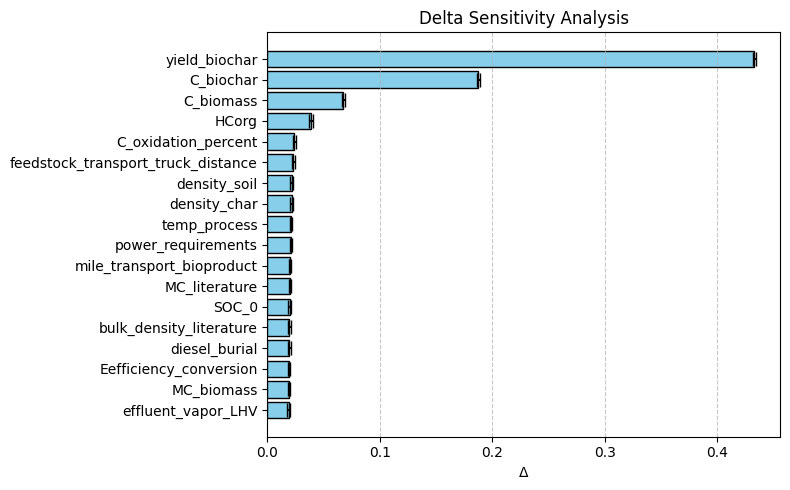

In [13]:
### Plotting delta sensitivity 

import matplotlib.pyplot as plt
import numpy as np

# Sort variables by delta (optional for nicer plotting)
sorted_idx = np.argsort(Si['delta'])[::-1]
names = np.array(Si['names'])[sorted_idx]
deltas = np.array(Si['delta'])[sorted_idx]
delta_conf = np.array(Si['delta_conf'])[sorted_idx]

# Plotting
plt.figure(figsize=(8, 5))
plt.barh(names, deltas, xerr=delta_conf, capsize=5, color='skyblue', edgecolor='k')
plt.xlabel('$\Delta$')
plt.title('Delta Sensitivity Analysis')
plt.gca().invert_yaxis()  # Highest delta at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
fname = 'sensitivity_'+str(n_samples)+'.png'
plt.savefig(fname)
# plt.show()

                                       delta  delta_conf        S1   S1_conf
C_biomass                           0.021156    0.001244  0.000347  0.000152
C_biochar                           0.201668    0.001207  0.261286  0.002729
effluent_vapor_LHV                  0.019535    0.000968  0.000327  0.000141
MC_biomass                          0.017729    0.000904  0.000434  0.000134
MC_literature                       0.018565    0.001082  0.000267  0.000111
bulk_density_literature             0.017299    0.001201  0.000454  0.000109
feedstock_transport_truck_distance  0.017918    0.001133  0.000410  0.000146
power_requirements                  0.021161    0.001157  0.000414  0.000147
temp_process                        0.019452    0.001084  0.000355  0.000130
yield_biochar                       0.486131    0.001106  0.720276  0.001428
Eefficiency_conversion              0.019374    0.001126  0.000539  0.000138
mile_transport_bioproduct           0.019956    0.001115  0.000444  0.000124

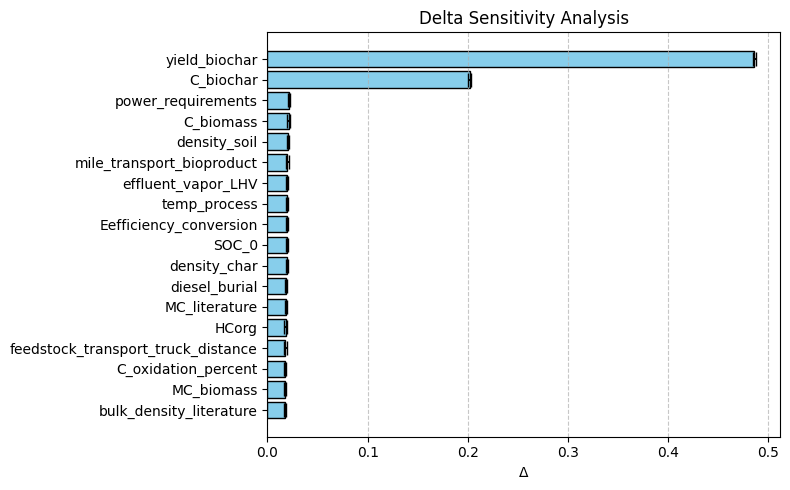

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Perform analysis for only sequestration
Si_seq = delta.analyze(problem, param_values, Y_seq, print_to_console=True)

# Sort variables by delta (optional for nicer plotting)
sorted_idx = np.argsort(Si_seq['delta'])[::-1]
names = np.array(Si_seq['names'])[sorted_idx]
deltas = np.array(Si_seq['delta'])[sorted_idx]
delta_conf = np.array(Si_seq['delta_conf'])[sorted_idx]

# Plotting
plt.figure(figsize=(8, 5))
plt.barh(names, deltas, xerr=delta_conf, capsize=5, color='skyblue', edgecolor='k')
plt.xlabel('$\Delta$')
plt.title('Delta Sensitivity Analysis')
plt.gca().invert_yaxis()  # Highest delta at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
fname = 'sensitivity_seq_'+str(n_samples)+'.png'
plt.savefig(fname)
# plt.show()

                                       delta  delta_conf        S1   S1_conf
C_biomass                           0.119631    0.001509  0.123490  0.002347
C_biochar                           0.176886    0.001668  0.230970  0.002885
effluent_vapor_LHV                  0.021718    0.001104  0.000347  0.000111
MC_biomass                          0.021809    0.001069  0.000567  0.000152
MC_literature                       0.019560    0.001033  0.000321  0.000121
bulk_density_literature             0.020215    0.001112  0.000326  0.000132
feedstock_transport_truck_distance  0.020051    0.001158  0.000362  0.000137
power_requirements                  0.018191    0.001254  0.001140  0.000242
temp_process                        0.020555    0.001027  0.000368  0.000134
yield_biochar                       0.385617    0.001330  0.628914  0.001710
Eefficiency_conversion              0.019279    0.001179  0.000271  0.000121
mile_transport_bioproduct           0.022443    0.000995  0.000338  0.000123

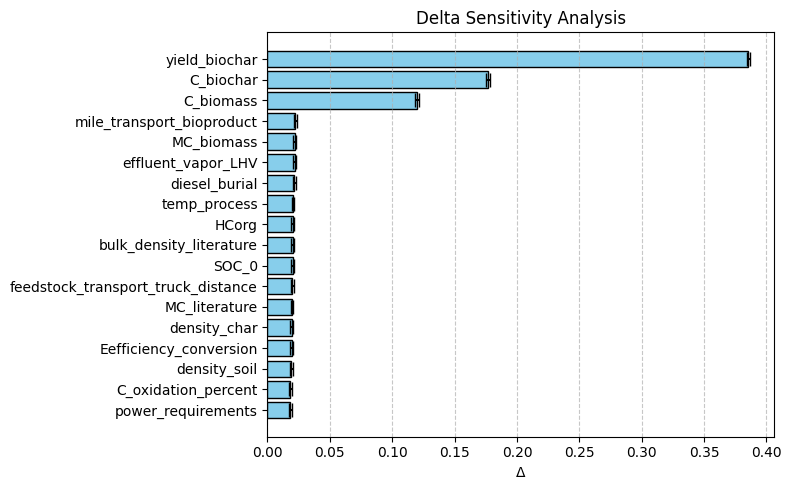

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Perform analysis for conversion 
Si_conversion = delta.analyze(problem, param_values, Y_conversion, print_to_console=True)

# Sort variables by delta (optional for nicer plotting)
sorted_idx = np.argsort(Si_conversion['delta'])[::-1]
names = np.array(Si_conversion['names'])[sorted_idx]
deltas = np.array(Si_conversion['delta'])[sorted_idx]
delta_conf = np.array(Si_conversion['delta_conf'])[sorted_idx]

# Plotting
plt.figure(figsize=(8, 5))
plt.barh(names, deltas, xerr=delta_conf, capsize=5, color='skyblue', edgecolor='k')
plt.xlabel('$\Delta$')
plt.title('Delta Sensitivity Analysis')
plt.gca().invert_yaxis()  # Highest delta at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
fname = 'sensitivity_conversion_'+str(n_samples)+'.png'
plt.savefig(fname)
# plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Perform analysis for soil and long term biochar emission
Si_longterm = delta.analyze(problem, param_values, Y_longterm, print_to_console=True)

# Sort variables by delta (optional for nicer plotting)
sorted_idx = np.argsort(Si_longterm['delta'])[::-1]
names = np.array(Si_longterm['names'])[sorted_idx]
deltas = np.array(Si_longterm['delta'])[sorted_idx]
delta_conf = np.array(Si_longterm['delta_conf'])[sorted_idx]

# Plotting
plt.figure(figsize=(8, 5))
plt.barh(names, deltas, xerr=delta_conf, capsize=5, color='skyblue', edgecolor='k')
plt.xlabel('$\Delta$')
plt.title('Delta Sensitivity Analysis')
plt.gca().invert_yaxis()  # Highest delta at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
fname = 'sensitivity_longterm_'+str(n_samples)+'.png'
plt.savefig(fname)
# plt.show()

In [8]:
# Define the model inputs
problem = {
    'num_vars':3,
    'names':['x1','x2','x3'],
    'bounds':[[-3.14, 3.14],
              [-3.14, 3.14],
              [-3.14, 3.14]]
}

# Genrate samples
param_values = latin.sample(problem, 1024)

# Run model (example)
Y = Ishigami.evaluate(param_values)

# Perform analysis
Si = delta.analyze(problem, param_values, Y, print_to_console=True)

# Print the first-order sensitivity indices
print(Si['S1'])

       delta  delta_conf        S1   S1_conf
x1  0.201765    0.020744  0.276942  0.039499
x2  0.258867    0.020178  0.285326  0.046772
x3  0.185249    0.019780  0.009681  0.010461
[0.27694234 0.28532611 0.00968068]
